In [1]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import yfinance as yf
import yahoo_fin.options as ops
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt


2024-05-21 05:03:25.712057: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 05:03:25.716045: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 05:03:25.773284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 05:03:26.710792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [2]:

# Load stock data
# DataFrame with columns: 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'
def get_ticker_data(ticker):
    df = get_data(ticker, start_date="01/01/2022")

    df.reset_index(inplace=True)
    df.rename(columns={'index': 'date'}, inplace=True)

    return df

your_data = get_ticker_data('META')

print(your_data.head())


        date        open        high         low       close    adjclose  \
0 2022-01-03  338.299988  341.079987  337.190002  338.540009  338.181183   
1 2022-01-04  339.950012  343.089996  331.869995  336.529999  336.173309   
2 2022-01-05  333.019989  335.760010  323.839996  324.170013  323.826416   
3 2022-01-06  322.820007  339.170013  322.720001  332.459991  332.107635   
4 2022-01-07  332.739990  337.000000  328.880005  331.790009  331.438354   

     volume ticker  
0  14537900   META  
1  15998000   META  
2  20564500   META  
3  27962800   META  
4  14722000   META  


In [3]:

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(your_data[['open', 'high', 'low', 'close']])

# Define function to create dataset
def create_dataset(data, look_back=1, index=3):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, index])  # Assuming you're predicting 'Close' price
    # print(X,Y)
    return np.array(X), np.array(Y)


In [7]:
col_names = ['open', 'high', 'low', 'close']

for i in range(4):
    # Split data into train and test sets
    train_size = int(len(scaled_data) * 0.8)
    test_size = len(scaled_data) - train_size
    train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

    # Create dataset for LSTM
    look_back = 7  # Number of previous days to use as input features
    train_X, train_Y = create_dataset(train_data, look_back, i)
    test_X, test_Y = create_dataset(test_data, look_back, i)

    # Reshape input data to be 3D [samples, time steps, features]
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 4))
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 4))


    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(look_back, 4)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')


    # Train the model
    model.fit(train_X, train_Y, epochs=100, batch_size=32)

    # Make predictions
    train_predict = model.predict(train_X)
    test_predict = model.predict(test_X)

    # Inverse scaling to get actual prices
    train_predict = scaler.inverse_transform(np.concatenate((np.zeros((len(train_predict), 3)), train_predict), axis=1))[:, i]
    test_predict = scaler.inverse_transform(np.concatenate((np.zeros((len(test_predict), 3)), test_predict), axis=1))[:, i]
    train_Y = scaler.inverse_transform(np.concatenate((np.zeros((len(train_Y), 3)), train_Y.reshape(-1, 1)), axis=1))[:, i]
    test_Y = scaler.inverse_transform(np.concatenate((np.zeros((len(test_Y), 3)), test_Y.reshape(-1, 1)), axis=1))[:, i]

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(train_Y, train_predict))
    test_rmse = np.sqrt(mean_squared_error(test_Y, test_predict))
    print('Train RMSE: %.2f' % train_rmse)
    print('Test RMSE: %.2f' % test_rmse)

    
    # save model for use 
    filename = f'LSTM_predict_{col_names[i]}.h5'
    model.save(filename)


Epoch 1/100


/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0900
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5592e-04 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0099e-04 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1657e-04 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7761e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0906e-04 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0794e-04 
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6523e-04 
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7127e-04 
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8946e-04 
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━

Train RMSE: 0.00
Test RMSE: 0.00
Epoch 1/100


/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0586
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012     
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4982e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9890e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6254e-04 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9787e-04 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6674e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4767e-04 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3288e-04 
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0977e-04 
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4991e-04 
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5117e-04
Epoch 15/100
15/15 ━━━━━━━━━━━

Train RMSE: 0.00
Test RMSE: 0.00
Epoch 1/100


/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0332
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5246e-04 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5790e-04 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0037e-04 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6345e-04 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4854e-04  
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3040e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3182e-04 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5739e-04 
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7519e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2126e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2220e-04 
Epoch 15/100
15/15 ━━━━━━━━━━━

Train RMSE: 0.00
Test RMSE: 0.00
Epoch 1/100


/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0657
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7514e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2671e-04 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9546e-04 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9014e-04 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8814e-04 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4897e-04 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0021e-04 
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3846e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3591e-04 
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2018e-04 
Epoch 15/100
15/15 ━━━━━━━━━━━━━

Train RMSE: 8.55
Test RMSE: 15.91


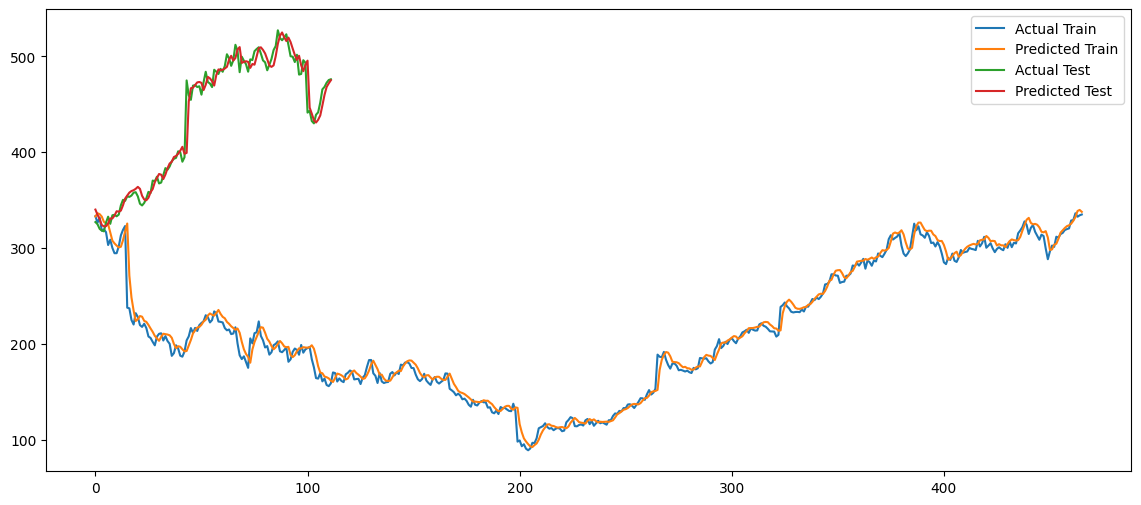

In [ ]:

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(train_Y, label='Actual Train')
plt.plot(train_predict, label='Predicted Train')
plt.plot(test_Y, label='Actual Test')
plt.plot(test_predict, label='Predicted Test')
plt.legend()
plt.show()



In [ ]:

new_data = np.array([
    # Sample 1: Past 7 days of data
    [[100, 110, 95, 1000],  # Day 1: [Open, High, Low, Volume]
     [102, 112, 98, 1200],  # Day 2
     [105, 115, 100, 1500],  # Day 3
     [108, 118, 102, 1800],  # Day 4
     [110, 120, 105, 2000],  # Day 5
     [112, 122, 108, 2200],  # Day 6
     [115, 125, 110, 2400]],  # Day 7
    # Sample 2: Past 7 days of data
    [[102, 112, 98, 1200],
     [105, 115, 100, 1500],
     [108, 118, 102, 1800],
     [110, 120, 105, 2000],
     [112, 122, 108, 2200],
     [115, 125, 110, 2400],
     [118, 128, 112, 2600]],
    # Sample 3: Past 7 days of data
    [[105, 115, 100, 1500],
     [108, 118, 102, 1800],
     [110, 120, 105, 2000],
     [112, 122, 108, 2200],
     [115, 125, 110, 2400],
     [118, 128, 112, 2600],
     [120, 130, 115, 2800]]
])

In [ ]:
def get_predictions(new_data, num_features=4):
    # Assuming you have prepared your new data as 'new_data' with the same preprocessing as the training data

    # Reshape new data to be 3D [samples, time steps, features]
    new_data = np.reshape(new_data, (new_data.shape[0], look_back, num_features))  # Adjust 'look_back' and 'num_features' accordingly

    # Make predictions using the trained model
    predictions = model.predict(new_data)

    # Reverse scaling to obtain actual predicted values
    predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), num_features-1)), predictions), axis=1))[:, num_features-1]
    return predictions

print(get_predictions(new_data=new_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
[696.89483426 676.91990912 664.61339927]
